This notebook is for Experiment 5: K-Means After Autoencoder

The aims of this notebook is to achieve the following:

• Train autoencoders with different bottleneck sizes (2, 5, 10, 15, 20)

• Compare with PCA results from Experiment 3

• Analyze reconstruction loss vs clustering performance

For ease of visualization and code readability, all codes previously made (K-Means and AE) will be rewritten in the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Load the breast cancer disgnostic dataset
dataset = load_breast_cancer()
features = dataset.data
target = dataset.target



In [2]:
# Metrics:

def mse(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

def silhouette_score(X, labels):
  clusters = np.unique(labels)
  samples = X.shape[0]

  # Compute distances matrix
  distances = np.zeros((samples, samples))
  for i in range(samples):
    for j in range(samples):
      distances[i, j] = np.linalg.norm(X[i] - X[j])

  # Compute scores
  scores = np.zeros(samples)
  for i in range(samples):
    cluster = labels[i]
    # Cohesion
    same_samples = np.where(labels == cluster)[0]
    same_samples = same_samples[same_samples != i]

    if len(same_samples) == 0:
      cohesion = 0
    else:
      cohesion = np.mean(distances[i, same_samples])

    # Separation
    separation = np.inf
    for j in clusters:
      if j != cluster:
        separation_j = np.mean(distances[i, labels == j])
        if separation_j < separation:
          separation = separation_j

    scores[i] = (separation - cohesion) / max(separation, cohesion)

  return np.mean(scores)

def davies_bouldin_index(X, labels):
    clusters = np.unique(labels)
    samples = X.shape[0]

    centroids = []
    dispersion = []

    # Intra-Cluster
    for cluster in clusters:
        cluster_points = X[labels == cluster]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        dispersion.append(np.mean(np.linalg.norm(cluster_points - centroid, axis=1)))

    dispersion = np.array(dispersion)
    centroids = np.array(centroids)

    # Inter-Cluster
    distances = np.linalg.norm(centroids[:, np.newaxis] - centroids[np.newaxis, :], axis=2)

    max_ratios =[]
    for i in range(len(clusters)):
      current_index_ratio = []
      for j in range(len(clusters)):
        if i != j:
          ratio = (dispersion[i]+dispersion[j]) / distances[i, j]
          current_index_ratio.append(ratio)
      max_ratios.append(np.max(current_index_ratio))

    return np.mean(max_ratios)

def calinski_harabasz_index(X, labels):
  clusters = np.unique(labels)
  samples = X.shape[0]

  mean_global = np.mean(X, axis=0)

  # Between-Cluster Variance
  between_cluster_sum_of_squares = 0
  within_cluster_sum_of_squares = 0

  for cluster in clusters:
      cluster_points = X[labels == cluster]
      mean_cluster = np.mean(cluster_points, axis=0)

      nSamples = cluster_points.shape[0]
      within_cluster_sum_of_squares += np.sum((cluster_points - mean_cluster)**2)
      between_cluster_sum_of_squares += nSamples * np.sum((cluster_points - mean_global)**2)

  index = ((between_cluster_sum_of_squares / (len(clusters) - 1))) / (within_cluster_sum_of_squares / (samples - len(clusters)))

  return within_cluster_sum_of_squares, index

def adjusted_rand_index(labels_true, labels_pred):
  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in range(0, len(labels_pred)-1):
    for j in range(i+1, len(labels_pred)):
      if labels_pred[i] == labels_pred[j]:
        # Positive Pair
        if labels_true[i] == labels_true[j]:
          # True
          TP += 1
        else: #False
          FP += 1
      else: # Negative Pair
        if labels_true[i] == labels_true[j]:
          # False
          FN += 1
        else: # True
          TN += 1

  total_pairs = TP+TN+FP+FN

  expected_index = ((TP+FP)*(TP+FN))/total_pairs
  max_index = ((TP+FP)+(TP+FN))/2

  # Prevent division by zero

  if (max_index-expected_index) == 0:
    return 0.0

  ari = (TP-expected_index)/(max_index-expected_index)

  return ari

def normalized_mutual_information(labels_true, labels_pred):
  clusters = np.unique(labels_pred)
  classes = np.unique(labels_true)

  matrix = np.zeros((len(classes), len(clusters)))

  for i, c in enumerate(classes):
    for j, k in enumerate(clusters):
      matrix[i, j] = np.sum((labels_true == c) & (labels_pred == k))

  # Entropy calculation
  pi_true = np.sum(matrix,axis=1)/len(labels_true)
  pi_pred = np.sum(matrix,axis=0)/len(labels_pred)

  pi_true = pi_true[pi_true > 0]
  pi_pred = pi_pred[pi_pred > 0]

  h_true = -np.sum(pi_true * np.log2(pi_true))
  h_pred = -np.sum(pi_pred * np.log2(pi_pred))

  mutual_information = 0

  for i in range(len(classes)):
    for j in range(len(clusters)):
      if matrix[i, j] > 0:
        # Probability of point being in class i and cluster j
        p_ij = matrix[i, j] / len(labels_true)
        # Probability of point being in class i
        p_i  = np.sum(matrix[i, :]) / len(labels_true)
        # Probability of point being in cluster j
        p_j  = np.sum(matrix[:, j]) / len(labels_true)
        mutual_information += p_ij * np.log2(p_ij / (p_i * p_j))

  if (h_true + h_pred) == 0:
    return 0.0

  return 2* mutual_information / (h_true + h_pred)

def purity(labels_true, labels_pred):
  clusters = np.unique(labels_pred)
  classes = np.unique(labels_true)

  matrix = np.zeros((len(classes), len(clusters)))

  for i, c in enumerate(classes):
    for j, k in enumerate(clusters):
      matrix[i, j] = np.sum((labels_true == c) & (labels_pred == k))

  dominant_class = np.max(matrix, axis=0)
  return np.sum(dominant_class) / len(labels_true)



In [3]:
# Autoencoder class from Autoencoder code
class Autoencoder():
  def __init__(self, layers=[30,20,15,5,2,5,15,20,30], activationFunctions = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid'], L2 = 0.0):
    self.layers = layers
    self.activationFunctions = activationFunctions
    self.L2 = L2
    self.gradients = {}
    self.parameters = {}
    self.cache = {}

    self.initializeParameters()

  def initializeParameters(self):
    np.random.seed(1)

    length = len(self.layers) - 1
    for i in range(1, length+1):
      layerInput = self.layers[i-1]
      layerOutput = self.layers[i]
      activationFunction = self.activationFunctions[i-1]

      # Intialization will vary
      # If the activation function is ReLU --> He intialization
      # Else if ['sigmoid', 'tanh'] --> Xavier
      # Else if linear, provide a simple, smaller scale

      if activationFunction == 'relu':
        layerScale = np.sqrt(2/layerInput)
      elif activationFunction in ['sigmoid', 'tanh']:
        layerScale = np.sqrt(2/(layerInput+layerOutput))
      else:
        layerScale = 0.01

      self.parameters['Weight'+str(i)] = np.random.randn(layerOutput, layerInput) * layerScale
      self.parameters['Bias'+str(i)] = np.zeros((layerOutput, 1))

    # Make methods for all activation functions (for the forward pass)
    # And derviatives for them for the backward pass

  def relu(self, z):
    return np.maximum(0,z)

  def tanh(self, z):
    return np.tanh(z)

  def sigmoid(self, z):
    return 1/(1+np.exp(-z))

  def linear(self, z):
    return z

  def reluDerivative(self, A):
    return (A > 0).astype(float)

  def tanhDerivative(self, A):
    return 1 - np.power(A, 2)

  def sigmoidDerivative(self, A):
    return A * (1-A)

  def linearDerivative(self, A):
    return np.ones(A.shape)


  def forwardPass(self, input):
    self.cache['Activation0'] = input
    length = len(self.layers) - 1

    afterActivation = input
    for i in range(1, length+1):
      weight = self.parameters['Weight'+str(i)]
      bias = self.parameters['Bias'+str(i)]

      Z = np.dot(weight, afterActivation) + bias
      self.cache['Z'+str(i)] = Z

      activationFunction = self.activationFunctions[i-1]
      if activationFunction == 'relu':
        afterActivation = self.relu(Z)
      elif activationFunction == 'tanh':
        afterActivation = self.tanh(Z)
      elif activationFunction == 'sigmoid':
        afterActivation = self.sigmoid(Z)
      elif activationFunction == 'linear':
        afterActivation = self.linear(Z)

      self.cache['Activation'+str(i)] = afterActivation

    return afterActivation


  def lossFunction(self, outputH, output):
    # Quantify loss using Mean Squared Error (MSE)
    cost = (1.0/(2*output.shape[1])) * np.sum((outputH-output)**2)

    # L2 Regularization

    if self.L2 > 0:
      length = len(self.layers) - 1
      sum = 0
      for i in range(1, length+1):
        sum += np.sum(np.square(self.parameters['Weight'+str(i)]))
        cost += (self.L2/(2*output.shape[1])) * sum

    return cost


  def backPropagation(self,output):
    # Compute all graidents for all layers

    length = len(self.layers) - 1
    dimensions = output.shape[1]
    outputH = self.cache['Activation'+str(length)]

    # Given that MSE was used for quantifying the loss:

    if self.activationFunctions[length-1] == 'linear':
      dZ = outputH - output
    elif self.activationFunctions[length-1] == 'sigmoid':
      dZ = (outputH - output)*self.sigmoidDerivative(outputH)
    elif self.activationFunctions[length-1] == 'tanh':
      dZ = (outputH - output)*self.tanhDerivative(outputH)
    elif self.activationFunctions[length-1] == 'relu':
      dZ = (outputH - output)*self.reluDerivative(outputH)

    self.gradients['dZ'+str(length)] = dZ


     # Back propagation:

    for i in range(length, 0, -1):
      # Obtain all responsible paramters for obtained output
      dZ = self.gradients['dZ'+str(i)]
      activation = self.cache['Activation'+str(i-1)]
      weight = self.parameters['Weight'+str(i)]

      # Calculate weight and bias graidents and include L2 regularization term
      self.gradients['dW'+str(i)] = (1.0/dimensions) * np.dot(dZ, activation.T)+(self.L2/dimensions)*weight
      # keepdims --> important for retaining the original shape of the bias matrix after the derivative
      self.gradients['dB'+str(i)] = (1.0/dimensions) * np.sum(dZ, axis=1, keepdims=True)

      # Error for both current and previous layers
      if i > 1:
        currentWeight = self.parameters['Weight'+str(i)]
        activationCurrent = self.cache['Activation'+str(i-1)]
        activationFunctionName = self.activationFunctions[i-2]
        dZ = np.dot(weight.T, dZ)

        if activationFunctionName == 'relu':
          dZ = dZ * self.reluDerivative(activationCurrent)
        elif activationFunctionName == 'tanh':
          dZ = dZ * self.tanhDerivative(activationCurrent)
        elif activationFunctionName == 'sigmoid':
          dZ = dZ * self.sigmoidDerivative(activationCurrent)
        elif activationFunctionName == 'linear':
          dZ = dZ

        self.gradients['dZ'+str(i-1)] = dZ

  def step(self, learningRate):
    length = len(self.layers) - 1
    for i in range(1, length+1):
      self.parameters['Weight'+str(i)] -= learningRate * self.gradients['dW'+str(i)]
      self.parameters['Bias'+str(i)] -= learningRate * self.gradients['dB'+str(i)]

  def fit(self, inputs, epochs=100, batchSize=64, learningRate=0.001, LRDecay=0.0, scale=50):
    dimensions = inputs.shape[1]
    cost = []

    for i in range(epochs):
      # Implementing a LR scheduling policy using the LRDecay parameter
      passLR = learningRate*(1.0/(1.0+LRDecay*i))

      epochLoss = 0
      numberOfBatches = 0
      # Mini batch training

      for j in range(0, dimensions, batchSize):
        inputBatch = inputs[:, j:j+batchSize]
        output = self.forwardPass(inputBatch)
        self.backPropagation(inputBatch)
        self.step(passLR)

        batchLoss = self.lossFunction(output,inputBatch)
        epochLoss += batchLoss
        numberOfBatches += 1

      lossPerEpoch = epochLoss/numberOfBatches

      if i%scale == 0:
        print(f"Epoch #{i}: Average Loss: {lossPerEpoch:.5f}")
        cost.append(lossPerEpoch)
    return cost

  def plot(self, cost):
    plt.plot(cost)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.grid(True)
    plt.show()

In [4]:
# K-Means Class From K-Means Code

class K_Means:
  def __init__(self, k=2, random_state=None):
    self.k = k
    self.random_state = random_state

  def kmeans_plusplus_init(self, X):
    if self.random_state is not None:
        np.random.seed(self.random_state)

    n_samples, n_features = X.shape
    centers = np.zeros((self.k, n_features))

    # Step 1: Choose first center randomly from data points
    first_center_idx = np.random.randint(0, n_samples)
    centers[0] = X[first_center_idx]
    print(f"Center 1 initialized at index {first_center_idx}")

    # Step 2: Choose remaining k-1 centers
    for i in range(1, self.k):
        # Calculate distance from each point to nearest existing center
        distances = np.zeros(n_samples)

        for j in range(n_samples):
            # Calculate distances to all existing centers
            dist_to_centers = np.zeros(i)
            for c in range(i):
                dist_to_centers[c] = np.sum((X[j] - centers[c]) ** 2)

            # Store minimum distance (squared distance to nearest center)
            distances[j] = np.min(dist_to_centers)

        # Choose next center with probability proportional to distance squared
        probabilities = distances / np.sum(distances)
        next_center_idx = np.random.choice(n_samples, p=probabilities)
        centers[i] = X[next_center_idx]
        print(f"Center {i+1} initialized at index {next_center_idx}")

    print(f"\nK-means++ initialization complete!")
    print(f"Initial centers shape: {centers.shape}")

    return centers

  def kmeans(self, X, k, centers, epochs, tolerance=1e-6):
    n_samples, n_features = X.shape
    labels = np.zeros(n_samples, dtype=int)
    inertia_history = []

    for epoch in range(epochs):
        # Step 1: Assignment - Assign each point to nearest center
        for i in range(n_samples):
            distances = np.zeros(k)
            for j in range(k):
                distances[j] = np.sum((X[i] - centers[j]) ** 2)
            labels[i] = np.argmin(distances)

        # Step 2: Update - Calculate new centers
        new_centers = np.zeros((k, n_features))
        for j in range(k):
            # Get all points assigned to cluster j
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centers[j] = np.mean(cluster_points, axis=0)
            else:
                # If no points assigned, keep old center
                new_centers[j] = centers[j]

        # Calculate inertia (sum of squared distances to nearest center)
        inertia = 0
        for i in range(n_samples):
            inertia += np.sum((X[i] - centers[labels[i]]) ** 2)
        inertia_history.append(inertia)

        # Check for convergence
        center_shift = np.sum(np.abs(new_centers - centers))
        if center_shift < tolerance:
            print(f"\nConverged at epoch {epoch + 1}! (Center shift {center_shift:.6f} < tolerance {tolerance})")
            centers = new_centers
            break

        centers = new_centers
    print(f"Final inertia: {inertia_history[-1]:.4f}")

    # Print cluster sizes
    print(f"\nCluster sizes:")
    for i in range(k):
        cluster_size = np.sum(labels == i)
        print(f"Cluster {i}: {cluster_size} points")

    return centers, labels, inertia_history

In [8]:
# Starting with experiment

def experiment(features_T, target, bottleNeckSize=[2,5,10,15,20]):

  results = {
      'dimensions':[], 'mse':[], 'silhouette':[], 'dbi':[], 'chi':[], 'purity':[], 'wcss':[], 'ari':[], 'nmi':[]
  }

  features = features_T.T
  classes = len(np.unique(target))

  for n in bottleNeckSize:
    layers=[30,n,30]
    activationFunctions = ['relu','sigmoid']

    ae = Autoencoder(layers=layers, activationFunctions=activationFunctions, L2=0.0)

    loss = ae.fit(features_T, epochs=1000, batchSize=64, learningRate=0.001, LRDecay=0.0, scale=100)
    print(f"\nGenerating Loss Curve for BottleNeckSize={n}\n")
    ae.plot(loss)

    reconstructed_T = ae.forwardPass(features_T)

    latent_T = ae.cache['Activation1']
    reduced_data = latent_T.T

    reconstruced = reconstructed_T.T
    mse = np.mean((features - reconstruced)**2)

    kmeans = K_Means(k=classes,random_state=42)
    initialCenters = kmeans.kmeans_plusplus_init(reduced_data)
    centers, labels, inertia_history = kmeans.kmeans(reduced_data, classes, initialCenters, epochs=100)

    sil = silhouette_score(reduced_data, labels)
    dbi = davies_bouldin_index(reduced_data, labels)
    wcss,chi = calinski_harabasz_index(reduced_data, labels)
    ari = adjusted_rand_index(target, labels)
    purity_score = purity(target, labels)
    nmi = normalized_mutual_information(target, labels)

    results['dimensions'].append(n)
    results['mse'].append(mse)
    results['silhouette'].append(sil)
    results['dbi'].append(dbi)
    results['chi'].append(chi)
    results['purity'].append(purity_score)
    results['wcss'].append(wcss)
    results['ari'].append(ari)
    results['nmi'].append(nmi)

    print(f"\nCurrent Dimensions (Bottleneck):{n}\n")
    print(f"MSE:{mse}\n")
    print(f"Silhouette Score:{sil}\n")
    print(f"Davies Bouldin Index:{dbi}\n")
    print(f"Calinski Harabasz Index:{chi}\n")
    print(f"Purity:{purity_score}\n")
    print(f"WCSS:{wcss}\n")
    print(f"ARI:{ari}\n")
    print(f"NMI:{nmi}\n")


    if n==2:
      print("\nConfusion Matrix\n")

      cm = confusion_matrix(target, labels)
      plt.figure()
      sb.heatmap(cm, annot=True, fmt='g',cbar=False,xticklabels=['Cluster 1', 'Cluster 0'], yticklabels=['Class 0', 'Class 1'])
      plt.xlabel('Predicted Cluster ID')
      plt.ylabel('True Label')
      plt.title('Confusion Matrix')
      plt.show()

      ae.plot(loss)

      uniqueLabels = np.unique(target)
      for l in uniqueLabels:
        plt.scatter(reduced_data[target == l, 0], reduced_data[target == l, 1], label=f'Cluster {l}')

      plt.title("AE (n=2)")
      plt.xlabel("Dimension 1")
      plt.ylabel("Dimension 2")
      plt.legend()
      plt.show()

  return results

def plotWCSS(results):
  plt.figure()
  plt.title("Elbow Curve")
  plt.xlabel("Number of dimensions")
  plt.ylabel("WCSS")
  plt.plot(results['dimensions'], results['wcss'], label='WCSS')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotInternal(results):
  plt.figure()
  plt.title("Internal Validation Metrics")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['silhouette'], label='Silhouette Score')
  plt.plot(results['dimensions'], results['dbi'], label='Davies Bouldin Index')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotCHI(results):
  plt.figure()
  plt.title("Calinski Harabasz Index")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['chi'], label='Calinski Harabasz Index')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotExternal(results):
  plt.figure()
  plt.title("External Validation Metrics")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['ari'], label='ARI')
  plt.plot(results['dimensions'], results['purity'], label='Purity')
  plt.plot(results['dimensions'], results['nmi'], label='NMI')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotReconstructionError(results):
  plt.figure()
  plt.title("Reconstruction Error")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['mse'], label='MSE')
  plt.legend()
  plt.grid(True)
  plt.show()


Experiment 5: K-Means After PCA

Epoch #0: Average Loss: 1.48207
Epoch #100: Average Loss: 1.35418
Epoch #200: Average Loss: 1.24262
Epoch #300: Average Loss: 1.14444
Epoch #400: Average Loss: 1.05787
Epoch #500: Average Loss: 0.98151
Epoch #600: Average Loss: 0.91413
Epoch #700: Average Loss: 0.85464
Epoch #800: Average Loss: 0.80205
Epoch #900: Average Loss: 0.75552

Generating Loss Curve for BottleNeckSize=2



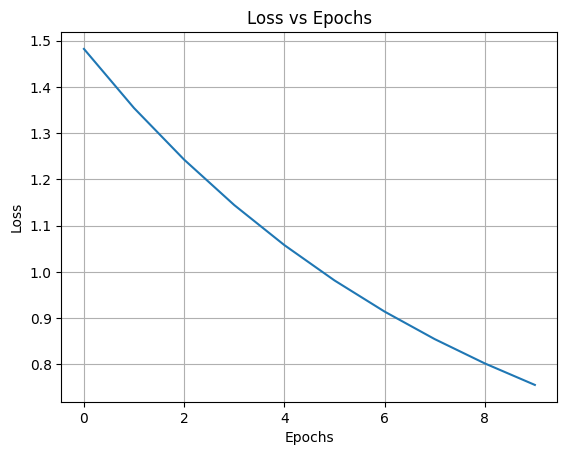

Center 1 initialized at index 102
Center 2 initialized at index 376

K-means++ initialization complete!
Initial centers shape: (2, 2)

Converged at epoch 3! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 0.4619

Cluster sizes:
Cluster 0: 553 points
Cluster 1: 16 points

Current Dimensions (Bottleneck):2

MSE:0.04759789618354227

Silhouette Score:0.9230505922934993

Davies Bouldin Index:0.3793504433008911

Calinski Harabasz Index:227212.62531244633

Purity:0.6274165202108963

WCSS:0.4618706494206083

ARI:-0.003593433470637225

NMI:0.0005806619942023304


Confusion Matrix



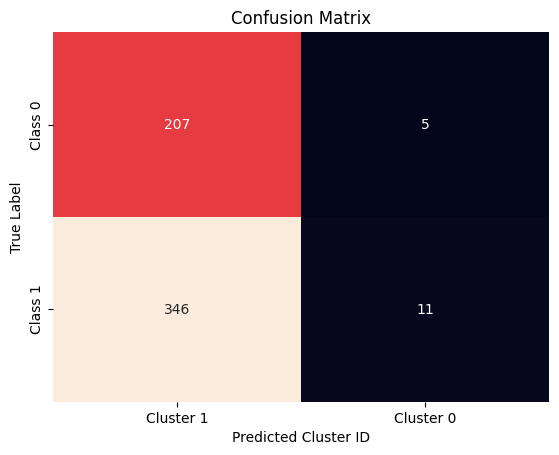

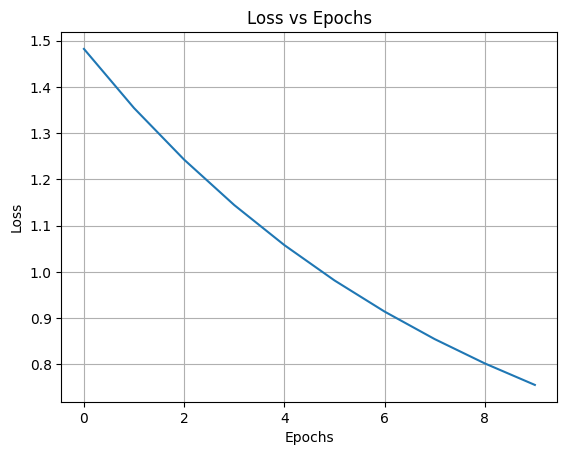

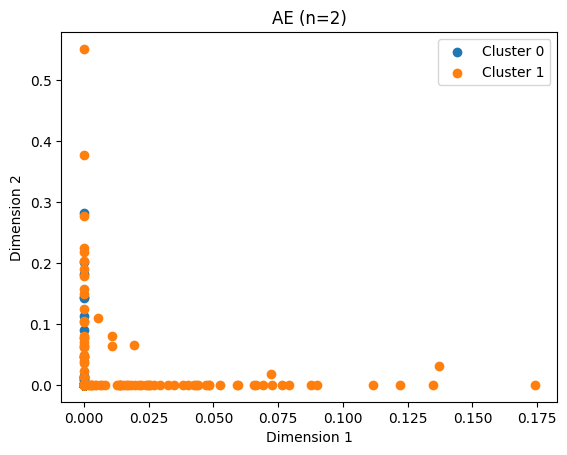

Epoch #0: Average Loss: 1.49993
Epoch #100: Average Loss: 1.30993
Epoch #200: Average Loss: 1.14312
Epoch #300: Average Loss: 0.96525
Epoch #400: Average Loss: 0.78403
Epoch #500: Average Loss: 0.63059
Epoch #600: Average Loss: 0.52630
Epoch #700: Average Loss: 0.46544
Epoch #800: Average Loss: 0.43155
Epoch #900: Average Loss: 0.41183

Generating Loss Curve for BottleNeckSize=5



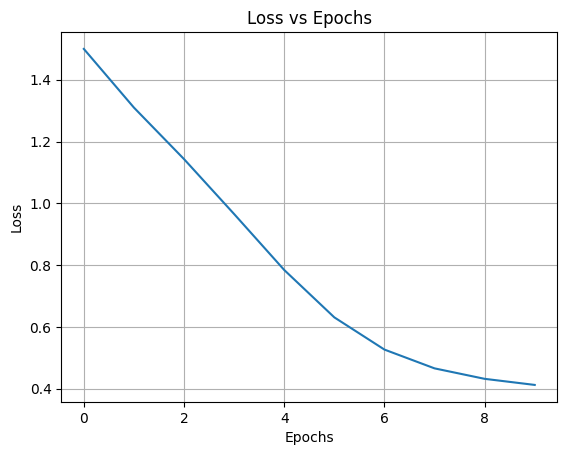

Center 1 initialized at index 102
Center 2 initialized at index 413

K-means++ initialization complete!
Initial centers shape: (2, 5)

Converged at epoch 6! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 94.8651

Cluster sizes:
Cluster 0: 379 points
Cluster 1: 190 points

Current Dimensions (Bottleneck):5

MSE:0.026619557641508848

Silhouette Score:0.5814498926702785

Davies Bouldin Index:0.6359052398986447

Calinski Harabasz Index:423099.30430973606

Purity:0.9050966608084359

WCSS:94.86505097033252

ARI:0.6534224243231076

NMI:0.5348575545729148

Epoch #0: Average Loss: 1.55524
Epoch #100: Average Loss: 1.36168
Epoch #200: Average Loss: 1.22597
Epoch #300: Average Loss: 1.10010
Epoch #400: Average Loss: 0.97466
Epoch #500: Average Loss: 0.84718
Epoch #600: Average Loss: 0.72212
Epoch #700: Average Loss: 0.61159
Epoch #800: Average Loss: 0.52649
Epoch #900: Average Loss: 0.46819

Generating Loss Curve for BottleNeckSize=10



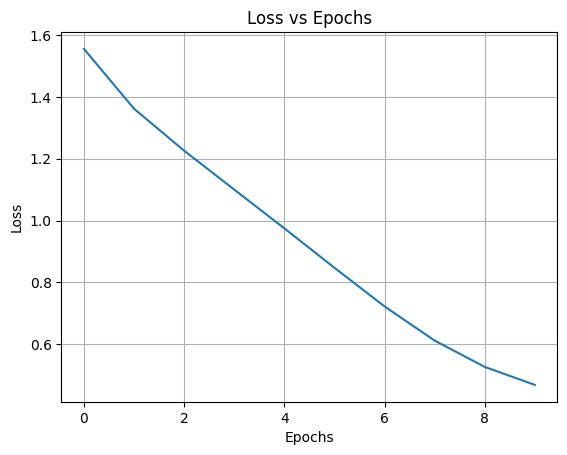

Center 1 initialized at index 102
Center 2 initialized at index 400

K-means++ initialization complete!
Initial centers shape: (2, 10)

Converged at epoch 7! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 71.6511

Cluster sizes:
Cluster 0: 380 points
Cluster 1: 189 points

Current Dimensions (Bottleneck):10

MSE:0.028706914909433452

Silhouette Score:0.5183689659534594

Davies Bouldin Index:0.7727398530213929

Calinski Harabasz Index:335633.25024141814

Purity:0.9173989455184535

WCSS:71.65108385768242

ARI:0.6942032088113927

NMI:0.5809943796320606

Epoch #0: Average Loss: 1.44353
Epoch #100: Average Loss: 1.19526
Epoch #200: Average Loss: 0.97037
Epoch #300: Average Loss: 0.76750
Epoch #400: Average Loss: 0.61201
Epoch #500: Average Loss: 0.51282
Epoch #600: Average Loss: 0.45705
Epoch #700: Average Loss: 0.42666
Epoch #800: Average Loss: 0.40907
Epoch #900: Average Loss: 0.39764

Generating Loss Curve for BottleNeckSize=15



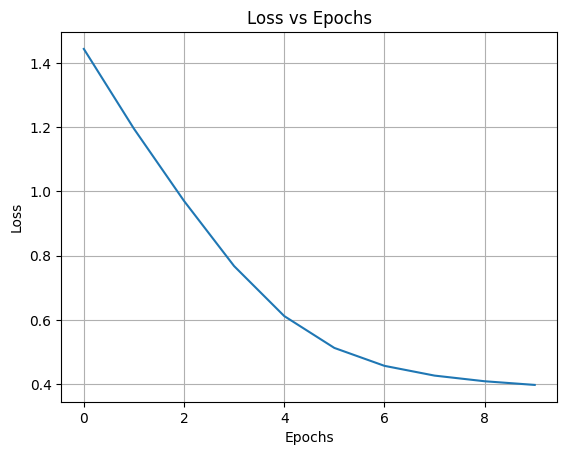

Center 1 initialized at index 102
Center 2 initialized at index 428

K-means++ initialization complete!
Initial centers shape: (2, 15)

Converged at epoch 8! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 151.4552

Cluster sizes:
Cluster 0: 187 points
Cluster 1: 382 points

Current Dimensions (Bottleneck):15

MSE:0.025954207932396417

Silhouette Score:0.5044304919491307

Davies Bouldin Index:0.7945943798430607

Calinski Harabasz Index:335233.6320232671

Purity:0.8998242530755711

WCSS:151.45519825455227

ARI:0.6361338547294898

NMI:0.5186443023912889

Epoch #0: Average Loss: 1.49318
Epoch #100: Average Loss: 1.20717
Epoch #200: Average Loss: 0.95628
Epoch #300: Average Loss: 0.74150
Epoch #400: Average Loss: 0.59724
Epoch #500: Average Loss: 0.51658
Epoch #600: Average Loss: 0.47273
Epoch #700: Average Loss: 0.44705
Epoch #800: Average Loss: 0.43029
Epoch #900: Average Loss: 0.41813

Generating Loss Curve for BottleNeckSize=20



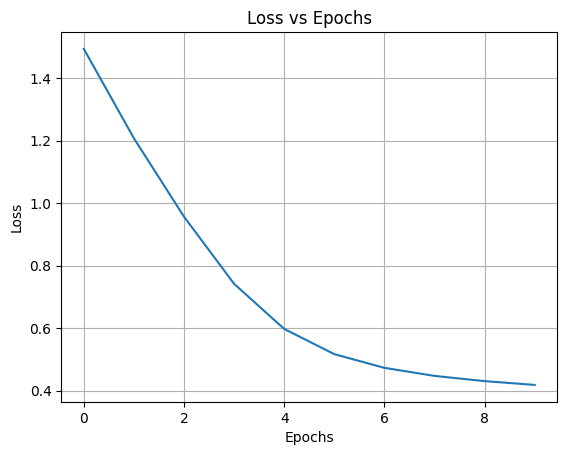

Center 1 initialized at index 102
Center 2 initialized at index 430

K-means++ initialization complete!
Initial centers shape: (2, 20)

Converged at epoch 4! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 179.2317

Cluster sizes:
Cluster 0: 384 points
Cluster 1: 185 points

Current Dimensions (Bottleneck):20

MSE:0.02723351022912579

Silhouette Score:0.503426892478981

Davies Bouldin Index:0.7959240189283283

Calinski Harabasz Index:333601.49239688826

Purity:0.9138840070298769

WCSS:179.23165027344507

ARI:0.6822165246881602

NMI:0.5719113235371456


Visulization



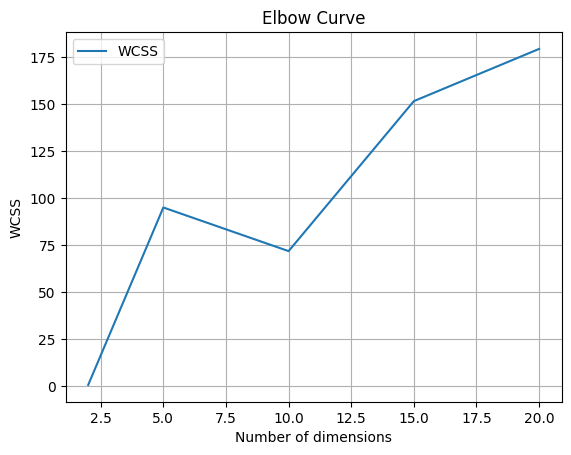

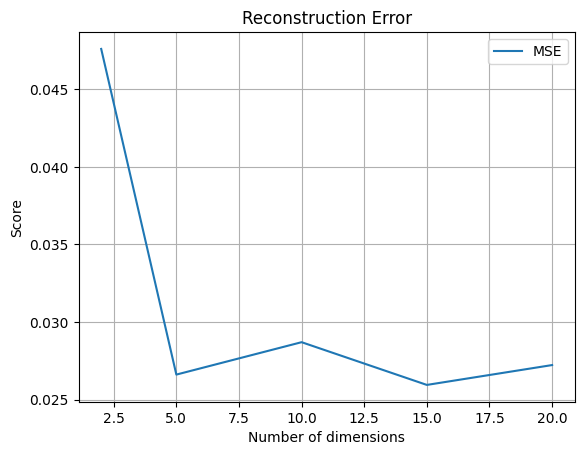

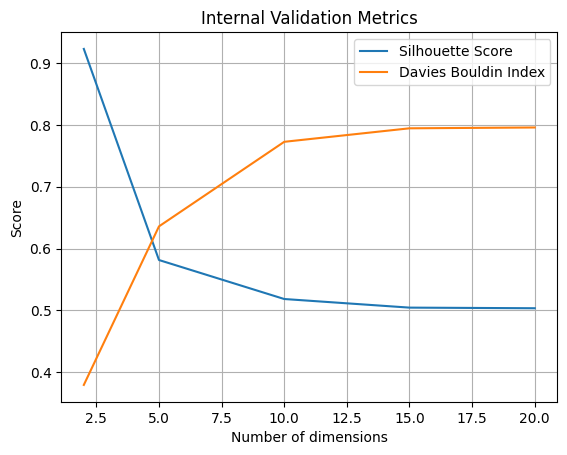

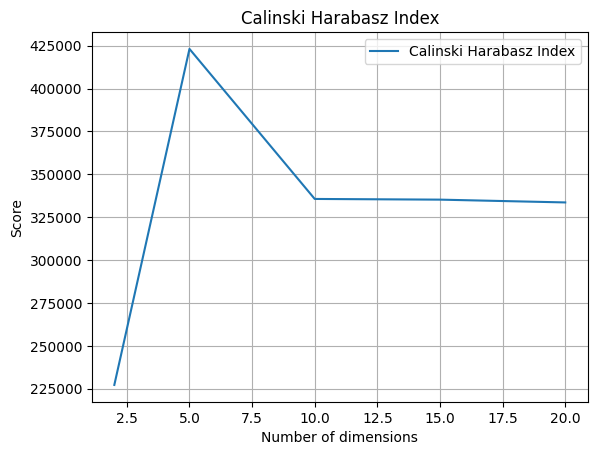

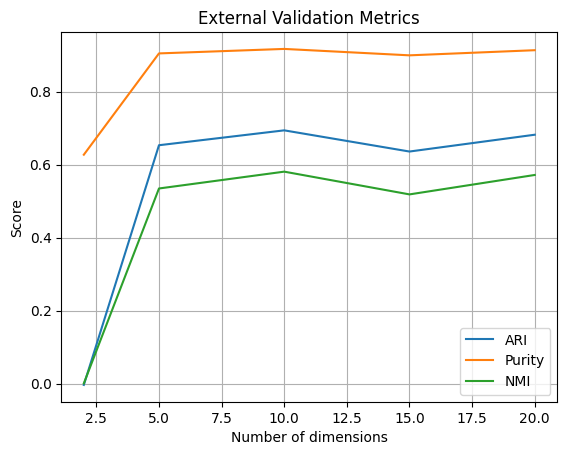

In [9]:
# Standardizing the data using a min-max scaler
minValue = np.min(features,axis=0)
maxValue = np.max(features,axis=0)

featuresStandardized = (features - minValue) / (maxValue - minValue)
featuresTranspose = featuresStandardized.T

print("Experiment 5: K-Means After PCA\n")
results = experiment(featuresTranspose, target, bottleNeckSize=[2,5,10,15,20])

print("\nVisulization\n")
plotWCSS(results)
plotReconstructionError(results)

plotInternal(results)
plotCHI(results)
plotExternal(results)

Note: the tests were run on an input of 9 layers. The output was way too noisy and contained numerous fluctuations. No regular patterns were easily obtained. Resorted to a simple 3 layer neural network instead. This is due to the simple data that is being dealt with (569 samples).

At a bottleneck of 2, AE completely collapsed. Cluster 0 contained 553 samples, while Cluster 1 contained only 16 samples. Why did AE fail? An AE optimizes primarily for reconstruction error. To do so, the average of the data is to be taken, thus destroying any possible bounds between the clusters.At this size, the compression is extreme and the network was not able to store any distinctive features about the malignant tumors. Accordingly, when K-Means considered the input space, one pile of data was present rather than two piles. PCA, on the other hand, aims to create orthogonal components to maximize the possible spread inherent in the data.

At a bottleneck of 10, the AE's non-linearity was able to capture subtle relationships that PCA's linearity was not able to compute.


Between both PCA and AE:

PCA proved to be more robust at higher degrees of compression, while the AE fully collapsed (ARI is almost 0).

When given a sufficient suitable capacity, the AE was able to achieve a higher ARI and Purity than that of the best PCA configuration.

This would incline one to belive that a higher bottleneck size would lead to a better output, yet comes the curse of dimensionality. With more than 10 dimensions, the points become too far apart that K-Means struggles in forming any dense centers. Moreover, as the dimensions increased, the model tended to memorize the data, along with its inherent accompanying background noise. Although the MSE metric would not capture such a thing (and would actually promote it), the quality of the cluster (ARI) would drop as the K-Means algorithm is now clustering based on noise, not on actual classes.